# P-Values for A/B conversion tests and machine learning classifier comparisons using the Binomial test

Website effectiveness measurement commonly uses user-centric measures such as a *conversion rate* (fraction of visitors that become effective clients) or a *click rate* (fraction of users that click or interact with something in the website). These measures must be calculated from real interactions, and each one of them is binary (representing whether the event happened).

* How to manipulate and predict website interactions using statistical models and Python's scipy module,
* How to decide if a modification in the website was effective in improving some metric.

Note that binary (yes/no) interactions are a premise of everything we are going to discuss next; if you are measuring continuous variables then you are probably looking for a t-test.


In [3]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')


## Users are coins - in the Bernoulli sense

When we say that a conversion rate (CR) is the fraction of visitors that become clients, we are stating the frequentist equivalent of saying that CR is the probability that a visitor becomes a client, or:
$$
\text{CR} = P(\text{Conversion}) = \frac{\text{number of conversions}}{\text{number of visitors}}.
$$

Each website visit has a binary outcome, outcomes do not impact each other, and the outcome depends on factors that are (in principle) unpredictable, we can model each one of these visits as the flip of a coin in which heads means "conversion" and tails means "no conversion". Moreover, each one of the outcomes is not equally likely, hence our visits can be modelled as biased coins. Consequently, we can safely use Bernoulli's experiments as mathematical equivalents of our website visits.

Because each visit is equivalent to a Bernoulli trial, then the number of favorable outcomes (the number of conversions!) is modelled by a binomial with parameters $n=\text{number of visitors}$ and $p=\text{CR}$. Since we *know* this theoretical distribution, we can ask ourselves questions like:

## If my website has $n$ visitors and a $p$ conversion rate, how many conversions should I expect (with 99% certainty)?

So, we are looking for the number immediately above 99% of the accumulated probability of a binomial. Python stats solves this problem with the `ppf` method:

In [4]:
n = 4000
p = 0.1
print(stats.binom.ppf(0.99, n=n, p=p))

445.0


Good, so for our current conversion rate we expect at most that number of conversions. This is important because then we can get our sales pipelines ready for that ammount of sales, and only miss deadlines 1% of the time.

Similarly, we could assess the **probability that we have at least $k$ conversions** using the `cdf`:

In [5]:
n = 10
p = 0.5
k = 6
print(1 - stats.binom.cdf(k-1, p=p, n=n))

0.376953125




But, then, at some point, we want to renew our website and check if we changed our conversion rate.

## Testing a new website version

Our procedure to test a new website version is really simple: we will show the new website to $n$ visitors and count the number $c$ of conversions. Then, we can ask ourselves: what is the probability that our current Binomial model (made with our known $p$) generates an outcome that is at least as distant from the expected value as $c$?

In [6]:
n = 50 # participants of our test
c = 10 # number of conversions
p = 0.1 # known value 
print(1-stats.binom.cdf(c-1, n=n, p=p))

0.024537935704591396


This probability is called the *p-value*. It is very low. However, we do know that:

* We observed $c$ conversions in $n$ participants,
* This behavior follows a Binomial distribution

The only thing we can discard is that the parameter $p$ we had assumed previously adequately models the conversion rate for the new website. Hence, we will *reject the hypothesis* that $p_{\text{new website}}=p_{\text{old website}}$. In other words, it is safe to assume that our website modification had some effect.

Well, this does not quite solve our problems, because this method cheated in the sense that it used a value for the binomial's $p$ that came out of nowhere. In practice, we almost never know this probability. 

## The A/B test

The essential procedure in an A/B test is really simple: when a visitor logs in the website, they are randomly assigned to one of its versions (the current (A) or the new one (B)). Then, the visit is recorded in a table that mentions (at least): the visit's unique ID, the group (A or B) and if the visit lead to a conversion, like:

| ID | Group | Conversion |
|:---:|:---:|:---:|
| 1 | A | Yes |
| 2 | B | No | 
| 3 | A | No |
| ... | ... | ... |

We could calculate the conversion rates for each group dividing the number of conversions by the number of visits, as: $p_a = c_a/n_a$ and $p_b = c_b/n_b$. Because of the reasons we discussed previously, these probabilities can be associated with binomial distributions. Our problem, then, is to find out whether $p_a$ and $p_b$ are, in fact, different.

For such, we can use the concept of p-values. If we assume that group B is associated with the same distribution as group A (that is, our null hypothesis is that $p_a=p_b$), what is the probability of observing *our data or a more disfavorable one*? In other words, we should estimate
$$ 
P(c > c_b | p_a=p_b).
$$

Then, if this probability (our p-value) is below a significance threshold that we can choose, we can reject the hypothesis that $p_a=p_b$, meaning that our intervention had some observable (or: statistically significant) effect.

As we discussed, we can calculate that probability using the cumulative distribution function, in something like:

In [7]:
na = 50 # participants of our test - group a
ca = 10 # number of conversions - group a
nb = 100 # participants of our test - group b
cb = 30 # number of conversions - group b
pa = ca/na
print(1-stats.binom.cdf(cb-1, n=nb, p=pa))

0.01124897872099162


This is called a "Binomial test", and can be directly calculated using an easier function directly from `scipy.stats`:

In [8]:
print(stats.binomtest(cb, n=nb, p=pa, alternative='greater'))
# Hurray! Another blog post to explain how a tiny, tiny function works!

BinomTestResult(k=30, n=100, alternative='greater', statistic=0.3, pvalue=0.011248978720991582)


# Increasing N

Ok, now lets suppose we increase the number of participants in our experimental test. What happens with our p-value? Let's test!

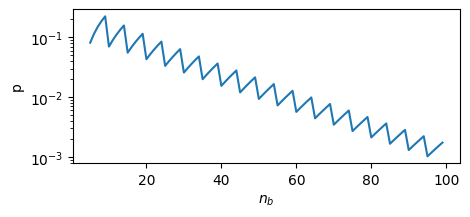

In [9]:
pa = 0.10
pb = 0.20

p = []
for nb in range(5, 100):
    cb = int(nb * pb) # We cannot have non-integer conversions
    p_ = 1-stats.binom.cdf(cb, n=nb, p=pa)
    p.append(p_)

plt.figure(figsize=(5,2))
plt.plot(list(range(5,100)), p)
plt.xlabel('$n_b$')
plt.ylabel('p')
plt.semilogy()
plt.show()

So we find a descending line with a ripple. This ripple is because the binomial distribution is discrete. As we can see, the ripple's absolute magnitude decreases when $n_b$ increases, that is, the ripple gets smaller as the binomial approaches the normal distribution.

Another important characteristic here is that the p-value decreases when $n_b$ increases. This means that, regardless of the difference between the conversinon probabilities of the two website versions, we would be able to see a statistically significant difference if the number of participants in the test was large enough.

# Another application: comparing classifiers

A problem that is probably going to show up in your life if you study or work with machine learning is testing a new classifier. You are probably going to estimate a class for each element in your test set, then decide if you were right or wrong. Note that attempting a classification is equivalent to flipping a biased coin, and being correct about the classification is equivalent to obtaining heads.

Hence, we could use the binomial test to detect whether the observed difference between our classifiers is statistically significant:

In [10]:
p0 = 0.77 # accuracy of previous classifier, as reported in their paper
n = 100 # number of elements in our *test set*
c = 83 # number of correct classifications in our test set
print("Accuracy (our system):", c/n)
print("p-value:", 1-stats.binom.cdf(c-1, n=n, p=p0))
print("p-value (with scipy):", stats.binomtest(c, n=n, p=p0, alternative='greater').pvalue)

Accuracy (our system): 0.83
p-value: 0.09256987367775582
p-value (with scipy): 0.09256987367775588


Importantly, it is still important to consider that, if the dataset size is too large, even a small change in accuracy might be considered significant, even to a very low confidence level. Hence, it is important to check if the effect size (the difference between $n/c$ and $p$) is *relevant* to the application.

# Next steps

So far, I have written about two different methods to calculate p-values, and they fit different contexts. However, both of them are very sensitive to the number $n$ of elements in the sample. This is because they both refer to null hypotheses related to *parameters* of random variables, and increasing $n$ decreases the uncertainty about these parameters. Thus, p-values are weak in large datasets, but are entirely necessary in smaller ones.

There are some new proposals for p-values, which I aim to investigate in the future. They claim to solve (or at least attenuate) the big data problem. Let's see how that goes!